# DQN from scratch

[Source](https://github.com/Curt-Park/rainbow-is-all-you-need/blob/master/01.dqn.ipynb). There are three key algorithmic features which contribute to the stability of DQN:  
1. Replay Buffer
2. Fixed Target Network
3. Gradient Clipping

## Imports & Constants

In [13]:
import time
import highway_env
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from abc import abstractmethod, ABC
from typing import Dict, List, Tuple
from typing_extensions import Self
from IPython.display import clear_output

from agents import BaseAgent

## Replay Buffer

In this simple implementation of a Replay Buffer, samples are drawn uniformly with no priority.

In [14]:
class ReplayBuffer:
    """
    Class representing a simple replay buffer that accepts stacked images.
    """
    
    def __init__(self, obs_shape: Tuple, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, *obs_shape], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, *obs_shape], dtype=np.float32)

        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)

        self.max_size = size
        self.batch_size = batch_size

        self.ptr = 0
        self.size = 0

    def store(self, obs: np.ndarray, act: np.ndarray, rew: np.ndarray, next_obs: np.ndarray, done: bool):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        # Draw `batch_size` no. samples (without replacement) as indices.
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            indices=idxs,
        )
    
    def __len__(self) -> int:
        return self.size

## Network

Contains three fully connected layers and two activation (non-linearity) functions.

In [15]:
class Network(nn.Module):
    """
    Class representing a feed-forward multi-layered percepton.
    """

    def __init__(self, in_dim: int, out_dim: int):
        """
        Instantiates a three-layer feed-forward neural network.
        """
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the neural network.
        """
        return self.layers(x)

## DQN Agent

In [16]:
class BaseDQNAgent(BaseAgent):
    """
    Abstract Base class for DQN agents.
    """

    def __init__(
        self,        
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float = 1e-4,
        seed: int = 42,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        super().__init__(env)

        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.memory_size = memory_size

        # FIXME
        self.obs_shape = env.observation_space.shape
        self.action_dim = env.action_space.n

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # DQN Networks (to be instantiated)
        self.dqn = None
        self.dqn_target = None
        self.optimiser = None

        # Experience Replay Buffer.
        self.memory = ReplayBuffer(self.obs_shape, memory_size, batch_size)
        # The next transition to store in memory.
        self.transition = list()

        self._init_seed(seed)
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """
        Takes an action and returns the response of the env.
        """
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        """
        Updates the model parameters by gradient descent.
        """
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)
        
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        return loss.item()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        self.is_test = False
        state, _ = self.env.reset()

        update_count = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(num_frames):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            if done:
                # The episode has ended.
                state, _ = self.env.reset()
                scores.append(score)
                score = 0

            if len(self.memory) >= self.batch_size:
                # Training is ready once the replay buffer contains enough transition samples.
                loss = self.update_model()
                losses.append(loss)
                update_count += 1

                # Linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon,
                    self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)

                # If a hard update of the target network is needed.
                if update_count % self.target_update == 0:
                    self._target_hard_update()

            if (frame_idx + 1) % plotting_interval == 0:
                self._plot(frame_idx + 1, scores, losses, epsilons)

        self.env.close()

        return (scores, losses, epsilons)

    def test(self, num_episodes: int, render: bool = True, time_interval: float = 0.2) -> Tuple[List, List]:
        self.is_test = True

        episode_lengths = []
        undiscounted_rewards = []
        for _ in range(num_episodes):
            done = truncated = False

            episode_reward = 0
            episode_length = 0

            obs, _ = self.env.reset()
            while not (done or truncated):
                action = self.predict(obs, True)
                obs, reward, done, truncated, _ = self.env.step(action)

                episode_reward += reward
                episode_length += 1

                if not render:
                    continue

                clear_output(True)
                plt.imshow(self.env.render())
                plt.show()
                time.sleep(time_interval)

            undiscounted_rewards.append(episode_reward)
            episode_lengths.append(episode_length)

        return episode_lengths, undiscounted_rewards
    
    def save(self, model_path: str):
        """
        Saves the Deep Q-Network model parameters to disk at `model_path`.
        """
        if not os.path.exists("./model/"):
            os.mkdir("model")

        torch.save(self.dqn.state_dict(), model_path)

    @classmethod
    def load(
        cls, 
        model_path: str,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        **kwargs
    ) -> Self:
        agent = cls(env, memory_size, batch_size, target_update, **kwargs)

        agent.dqn.load_state_dict(torch.load(model_path))
        agent.dqn_target.load_state_dict(torch.load(model_path))
        
        # agent.dqn.eval()
        agent.dqn_target.eval()

        return agent
    
    @abstractmethod
    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float = None) -> torch.Tensor:
        """
        Computes and returns the DQN loss.
        """
        raise NotImplementedError()

    def _target_hard_update(self):
        """
        Performs a hard update of the target network: target <- behavioural.
        """
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plots the training progress."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-25:])))
        # Plot the rolling mean score of the last 25 episodes.
        plt.plot(self._calculate_rolling_mean(scores, 25))
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses[20:])
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

    @staticmethod
    def _calculate_rolling_mean(data: List, window_size: int) -> np.ndarray:
        window = np.ones(window_size) / window_size
        return np.convolve(data, window, mode='valid')


class MlpDQNAgent(BaseDQNAgent):
    """
    Class representing a DQN agent utilising MLP Feed-Forward Neural Networks.
    """

    def __init__(
        self,        
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float = 1e-4,
        seed: int = 42,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        super().__init__(
            env, 
            memory_size, 
            batch_size, 
            target_update, 
            epsilon_decay, 
            seed, 
            max_epsilon, 
            min_epsilon, 
            gamma
        )

        # Networks: DQN behaviour network, DQN target network
        self.obs_dim = np.prod(self.obs_shape)
        self.dqn = Network(self.obs_dim, self.action_dim).to(self.device)
        self.dqn_target = Network(self.obs_dim, self.action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # Optimiser
        self.optimiser = optim.Adam(self.dqn.parameters())

    def select_action(self, state: np.ndarray, determinstic: bool = False) -> np.ndarray:
        """
        Selects an action from the input state using an epsilon-greedy policy.
        """
        if not determinstic and np.random.random() < self.epsilon:
            selected_action = self.env.action_space.sample()
        else:
            flattened_state = state.flatten()
            selected_action = self.dqn(
                torch.FloatTensor(flattened_state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float = None) -> torch.Tensor:
        """
        Computes and returns the DQN loss.
        """
        if gamma is None:
            gamma = self.gamma

        device = self.device
        # Shape = (batch_size, obs dim 1, obs dim 2, ...)
        # This flattens the observation dimensions of `state` and `next_state`.
        state = torch.FloatTensor(samples["obs"].reshape(self.batch_size, -1)).to(device)
        next_state = torch.FloatTensor(samples["next_obs"].reshape(self.batch_size, -1)).to(device)

        # Reshapes each 1-dimesional array into a 2-dimensional array with one column.
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t = r + gamma * v(s_{t+1}) if state != terminal
        #     = r                      otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim=1, keepdim=True)[0].detach()
        
        mask = 1 - done
        target = (reward + gamma * next_q_value * mask).to(device)

        # Calculate DQN loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

# Train an agent

In [17]:
config = {
    'duration': 50,
    'lanes_count': 4,
}

In [18]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config)
obs, info = env.reset()

In [19]:
seed = 777
num_frames = 200_000
memory_size = 10_000
gamma = 0.85
batch_size = 64
target_update = 50
epsilon_decay = 1 / (num_frames // 10)

agent = MlpDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

cuda


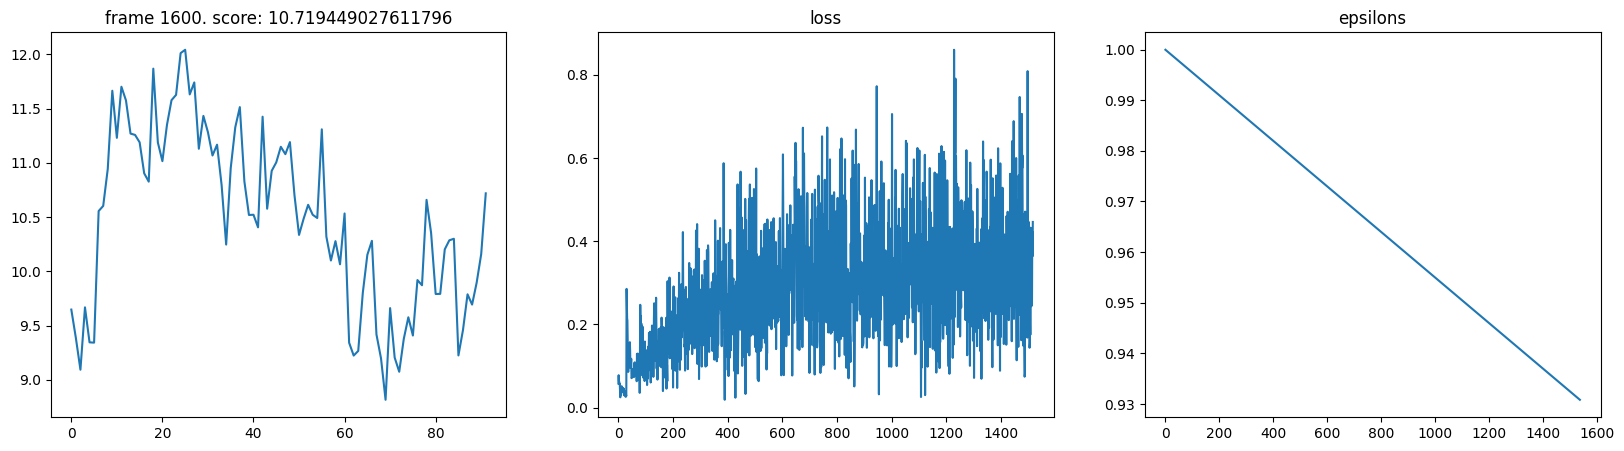

KeyboardInterrupt: 

In [20]:
scores, losses, epsilons = agent.train(num_frames)

In [19]:
# pd.DataFrame(dict(DQN=scores)).to_csv("../results/dqn.csv")

# Test the agent after training

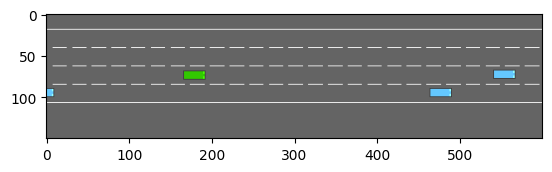

In [20]:
ep_lens, ep_rews = agent.test(1, time_interval=0.01)

In [21]:
print("Mean Episode Length:", np.mean(ep_lens))
print("Mean Score Per Episode:", np.mean(ep_rews))

Mean Episode Length: 50.0
Mean Score Per Episode: 47.190874002149684


# Film the agent

In [34]:
env = gym.make("highway-v0", render_mode="rgb_array")

In [35]:
def film(env: gym.Env, test_agent: BaseDQNAgent, film_length: int, video_folder: str):
    vid_env = RecordVideo(env, video_folder=video_folder,
              episode_trigger=lambda e: True)  # record all episodes

    # Provide the video recorder to the wrapped environment
    # so it can send it intermediate simulation frames.
    vid_env.unwrapped.set_record_video_wrapper(vid_env)

    test_agent.set_mode(is_test=True)

    for i in range(film_length):
        obs, info = vid_env.reset()
        done = truncated = False

        while not (done or truncated):
            action = test_agent.predict(obs, determinstic=True)
            obs, reward, done, truncated, info = vid_env.step(action)
            vid_env.render()
        vid_env.close()

## Before Training

In [37]:
untrained_agent = MlpDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

film(env, untrained_agent, 10, "../videos/dqn/untrained/")

cuda


/home/sowell/projects/rl_group_assignment/venv/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/sowell/projects/rl_group_assignment/videos/dqn/untrained folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-0.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-1.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-1.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-2.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-2.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-3.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-3.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-4.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-4.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-5.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-5.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-6.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-6.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-7.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-7.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-8.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-8.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-9.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/untrained/rl-video-episode-9.mp4


## After training

In [36]:
film(env, agent, 10, "../videos/dqn/trained/")

/home/sowell/projects/rl_group_assignment/venv/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/sowell/projects/rl_group_assignment/videos/dqn/trained folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-0.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-1.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-1.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-2.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-2.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-3.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-3.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-4.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-4.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-5.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-5.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-6.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-6.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-7.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-7.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-8.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-8.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-9.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn/trained/rl-video-episode-9.mp4
